Get Data from URL, cleanse the data, and write data to 'lyrics.txt' file

In [23]:
import requests
from bs4 import BeautifulSoup
import re
import os
import codecs

url = 'https://stixoi.info/stixoi.php?info=Lyrics&act=index&sort=alpha&singer_id=1820'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

f = open('lyrics.txt', 'w', encoding='utf-8')
tempsoup = soup.find_all('td', class_='row1') 
for i in range(1, 622, 9):
    link = str(tempsoup[i].find('a'))
    song_id = re.search('(?<=song_id=)(.*)(?=")', link)
    song_id = song_id.group()
    song_lyrics_url = "https://stixoi.info/stixoi.php?info=Lyrics&act=details&song_id="+song_id
    page = requests.get(song_lyrics_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    lyrics = soup.find_all('div', class_='lyrics')
    lyrics = lyrics[0].get_text()
    
    #Remove empty lines from final lyrics
    lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
    f.write(lyrics)

f.close()

Import tensorflow libraries and numpy

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Prepare Data

In [4]:
data = open('lyrics.txt', encoding = 'utf-8').read()
corpus = data.lower().split("\n")

tokenizer = Tokenizer() #oov_token="<OOV>"
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))



# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
#Some code for debugging 

'''
word_index = tokenizer.word_index
print(word_index)
'''

'''
print(input_sequences[3])
print(input_sequences.shape)
'''

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  1]
(8613, 18)


## Initialize NN model (for this code to run it was needed to downgrade to numpy version == 1.18.5

In [5]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(120, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(96))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 128)           288896    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 240)           239040    
_________________________________________________________________
dropout (Dropout)            (None, 17, 240)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                129408    
_________________________________________________________________
dense (Dense)                (None, 1128)              109416    
_________________________________________________________________
dense_1 (Dense)              (None, 2257)              2548153   
Total params: 3,314,913
Trainable params: 3,314,913
Non-trainable params: 0
______________________________________________

In [7]:
history = model.fit(predictors, label, epochs=100, verbose=1)


Epoch 1/100
270/270 [==============================] - 7s 13ms/step - loss: 6.8635 - accuracy: 0.0399
Epoch 2/100
270/270 [==============================] - 3s 12ms/step - loss: 6.2767 - accuracy: 0.0426
Epoch 3/100
270/270 [==============================] - 3s 12ms/step - loss: 6.1754 - accuracy: 0.0424
Epoch 4/100
270/270 [==============================] - 3s 12ms/step - loss: 6.0548 - accuracy: 0.0512
Epoch 5/100
270/270 [==============================] - 4s 13ms/step - loss: 5.9363 - accuracy: 0.0551
Epoch 6/100
270/270 [==============================] - 4s 13ms/step - loss: 5.8511 - accuracy: 0.0604
Epoch 7/100
270/270 [==============================] - 4s 14ms/step - loss: 5.7796 - accuracy: 0.0665
Epoch 8/100
270/270 [==============================] - 4s 14ms/step - loss: 5.6978 - accuracy: 0.0686
Epoch 9/100
270/270 [==============================] - 4s 14ms/step - loss: 5.6093 - accuracy: 0.0723
Epoch 10/100
270/270 [==============================] - 4s 14ms/step - loss: 5.534

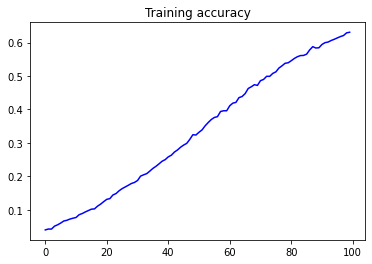

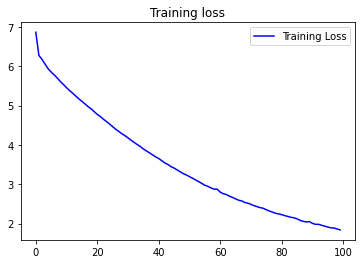

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [29]:
seed_text = ""
next_words = 6
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


το πανεπηστίμιο σκοτάδι το φεγγάρι πως φωτίζουν μια


In [30]:
#Save the model
model.save('greekLyrics.h5')

In [ ]:
#Load the model
model = tf.keras.models.load_model('greekLyrics.h5')